In [1]:
%%capture

from lmi import lmi

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from tqdm.notebook import tqdm

import scanpy as sc

In [2]:
adata = sc.read('../data/LARRY_HVGs_preprocessed.h5ad')
early_clones = adata[adata.obs['time'].isin([2,4])]
late_clones = adata[adata.obs['time'] == 6]
common_clones = set([x for x in early_clones.obs['clone'].values 
                     if x in late_clones.obs['clone'].values])
print("Number of common clones: %d" %(len(common_clones)))

Number of common clones: 3320


In [3]:
cxf = adata.to_df()
for name in adata.obs.keys():
    cxf[name] = adata.obs[name].values
rnas = cxf.keys()[:-7]

In [4]:
pMIs = []
N_pairings = 20
for _ in range(N_pairings):
    
    early = cxf[(cxf['time'].isin([2,4])) 
                & (cxf['clone'].isin(common_clones))].groupby('clone').sample(n=1)
    late = cxf[(cxf['time'] == 6) & (cxf['clone'].isin(
        common_clones))].groupby('clone').sample(n=1)
    
    p, _, _ = lmi.lmi(early[rnas], late[rnas], quiet=True)
    pMIs.append(np.nan_to_num(p))

In [5]:
pMIs = np.vstack(pMIs).mean(axis=0)

In [6]:
early['pMI'] = pMIs
late['pMI'] = pMIs
early = early.dropna()

In [7]:
# filter for neutrophil lineage

neutros = early[early['Neutrophil PT'] > 10000]

neutros = neutros.sort_values(by='Neutrophil PT', ascending=True)

# compute a smoothed pSIMI over window of 100 cells along pseudotime
neutros['smooth pMI'] = neutros['pMI'].rolling(100).mean()

neutros['NPT'] = np.arange(len(neutros))

<Axes: xlabel='Neutrophil PT', ylabel='smooth pMI'>

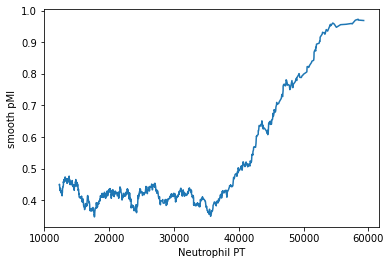

In [8]:
sns.lineplot(neutros, x="Neutrophil PT", y='smooth pMI')

(-2239.8674, 3292.2614, -2452.6952, 1932.6572)

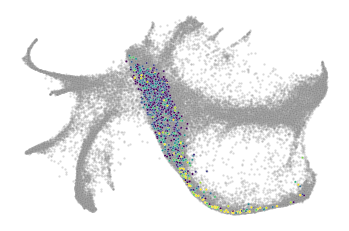

In [9]:
rcParams['figure.figsize'] = (6,4)
sns.scatterplot(cxf,
                x='SPRING1', y="SPRING2", c='gray', s=5, alpha=0.3)
sns.scatterplot(neutros,
               x='SPRING1', y='SPRING2', hue='pMI', s=5, palette='viridis',
               hue_norm=(0.2, 1.2), legend=False)
plt.axis('off')

(-2239.8674, 3292.2614, -2452.6952, 1932.6572)

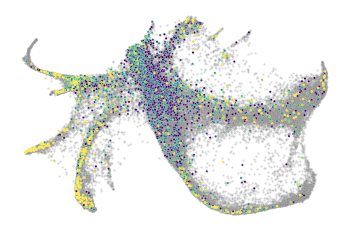

In [10]:
rcParams['figure.figsize'] = (6,4)
sns.scatterplot(cxf,
                x='SPRING1', y="SPRING2", c='gray', s=5, alpha=0.3)
sns.scatterplot(early,
               x='SPRING1', y='SPRING2', hue='pMI', s=5, palette='viridis',
                hue_norm=(0.2,1.2), legend=False)
plt.axis('off')

In [11]:
cxf[['SPRING1', 'SPRING2', 'type', 'Neutrophil PT']].to_csv("../results/LARRY_basic_vis.csv")
early[['SPRING1', 'SPRING2', 'pMI']].to_csv('../results/H_pMI_vis.csv')
neutros[['SPRING1', 'SPRING2', 'Neutrophil PT', 'pMI', 'smooth pMI']].to_csv(
    "../results/H_neutros_pSIMI.csv"
)